# Packages

In [23]:
# Data wrangling
import pandas as pd
import polars as pl
import polars.selectors as cs
import numpy as np

# Visualisation
import plotnine as pn
import matplotlib.pyplot as plt
from mizani.formatters import comma_format, custom_format, currency_format, percent_format
from IPython.display import clear_output, display
import matplotlib.font_manager as fm
import matplotlib as mpl
from matplotlib import rc
import plotly.express as px

# Utils
import os
from tqdm.notebook import tqdm
import itertools
import yaml
import warnings
import time
import holidays

# Modelling
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    FunctionTransformer,
)
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_absolute_percentage_error,
    root_mean_squared_error,
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer


from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsforecast.models import AutoARIMA, ARIMA
from statsforecast.utils import AirPassengers as ap

import ray
from ray import train, tune
from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler


rc('text', usetex=False)

jama_colour = [
    "#374e55",
    "#df8f44",
    "#00a1d5",
    "#b24745",
    "#79af97",
    "#6a6599",
    "#80796b",
]

pd.set_option("display.max.columns", 500)
pd.set_option("display.max.columns", 500)


theme_academic = pn.theme(
    text=pn.element_text(family="Latin Modern Roman"),
    plot_title=pn.element_text(weight="bold", size=14, ha="center"),
    legend_text=pn.element_text(size=9),  # Smaller font for legend items
    panel_background=pn.element_rect(fill="white"),  # Clean white background
    panel_border=pn.element_rect(color="grey", size=0.5),
    axis_ticks=pn.element_line(color="grey"),
    panel_grid_major=pn.element_line(color="grey", size=0.1, alpha=0.3),
    panel_grid_minor=pn.element_line(color="grey", size=0.1, alpha=0.3),
    legend_background=pn.element_rect(fill="white", color=None),
    legend_key=pn.element_rect(fill="white", color=None),
    plot_margin=0.02,
    figure_size=(6, 4),  # Set default figure size (width, height in inches)
)

%matplotlib inline

# Loading the data

In [24]:
df = pl.read_csv("../0_data/preprocessed/df_final.csv", try_parse_dates=True)


df.head()

datetime,kWh,Basel_temperature_2m,Basel_relative_humidity_2m,Basel_dew_point_2m,Basel_apparent_temperature,Basel_precipitation,Basel_rain,Basel_snowfall,Basel_snow_depth,Basel_cloud_cover,Basel_wind_speed_10m,Basel_wind_speed_100m,Basel_wind_direction_10m,Basel_wind_direction_100m,Basel_wind_gusts_10m,Basel_soil_temperature_0_to_7cm,Basel_soil_temperature_7_to_28cm,Basel_soil_temperature_28_to_100cm,Basel_soil_temperature_100_to_255cm,Basel_soil_moisture_0_to_7cm,Basel_soil_moisture_7_to_28cm,Basel_soil_moisture_28_to_100cm,Basel_soil_moisture_100_to_255cm,Basel_shortwave_radiation,Bern_temperature_2m,Bern_relative_humidity_2m,Bern_dew_point_2m,Bern_apparent_temperature,Bern_precipitation,Bern_rain,Bern_snowfall,Bern_snow_depth,Bern_cloud_cover,Bern_wind_speed_10m,Bern_wind_speed_100m,Bern_wind_direction_10m,…,St_wind_speed_10m,St_wind_speed_100m,St_wind_direction_10m,St_wind_direction_100m,St_wind_gusts_10m,St_soil_temperature_0_to_7cm,St_soil_temperature_7_to_28cm,St_soil_temperature_28_to_100cm,St_soil_temperature_100_to_255cm,St_soil_moisture_0_to_7cm,St_soil_moisture_7_to_28cm,St_soil_moisture_28_to_100cm,St_soil_moisture_100_to_255cm,St_shortwave_radiation,Zurich_temperature_2m,Zurich_relative_humidity_2m,Zurich_dew_point_2m,Zurich_apparent_temperature,Zurich_precipitation,Zurich_rain,Zurich_snowfall,Zurich_snow_depth,Zurich_cloud_cover,Zurich_wind_speed_10m,Zurich_wind_speed_100m,Zurich_wind_direction_10m,Zurich_wind_direction_100m,Zurich_wind_gusts_10m,Zurich_soil_temperature_0_to_7cm,Zurich_soil_temperature_7_to_28cm,Zurich_soil_temperature_28_to_100cm,Zurich_soil_temperature_100_to_255cm,Zurich_soil_moisture_0_to_7cm,Zurich_soil_moisture_7_to_28cm,Zurich_soil_moisture_28_to_100cm,Zurich_soil_moisture_100_to_255cm,Zurich_shortwave_radiation
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2009-01-01 00:00:00,6.9844e6,-1.4965,94.97623,-2.1965,-4.269863,0.1,0.0,0.07,0.06,57.899998,2.2768397,3.8268526,161.56496,228.81418,8.28,-0.7965,0.2535,3.2535,8.3535,0.477,0.468,0.47,0.47,0.0,-0.496,95.016594,-1.196,-3.113932,0.4,0.1,0.21,0.29,95.7,2.16,3.8939953,270.0,…,4.198285,8.350138,149.03632,172.56868,11.879999,1.0435,1.6435,4.0435004,7.3435,0.368,0.375,0.392,0.405,0.0,0.0005,95.03646,-0.6995,-2.498038,0.3,0.1,0.14,0.05,91.8,1.835647,4.896529,168.69011,162.89719,7.2,-0.5495,0.4505,2.9505,7.2505,0.4,0.376,0.406,0.41,0.0
2009-01-01 01:00:00,6.7564e6,-1.8465,94.96198,-2.5465,-4.892221,0.0,0.0,0.07,0.06,78.3,3.8268526,8.049845,221.18582,259.69522,9.0,-0.7965,0.2535,3.2535,8.3535,0.475,0.468,0.47,0.47,0.0,-1.046,94.99447,-1.746,-3.901534,0.2,0.1,0.07,0.29,64.799995,3.2599385,8.350138,263.6599,…,4.6800003,6.8399997,157.3801,180.0,11.159999,1.0435,1.6435,4.0435004,7.3435,0.367,0.375,0.391,0.405,0.0,-0.0495,95.381744,-0.6995,-2.496816,0.2,0.1,0.07,0.05,99.899994,1.484318,3.0547013,284.03625,224.9999,8.28,-0.5495,0.4505,2.9005,7.2505,0.399,0.376,0.406,0.41,0.0
2009-01-01 02:00:00,6.5171e6,-1.2965,96.03991,-1.8465,-4.322661,0.0,0.0,0.07,0.06,50.100002,4.3349743,9.826088,228.36655,261.57312,9.36,-0.7965,0.2535,3.2535,8.3535,0.473,0.468,0.47,0.47,0.0,-0.846,94.6542,-1.596,-3.819829,0.0,0.0,0.07,0.29,72.6,4.2136917,10.365251,289.9832,…,2.968636,6.297428,194.03627,210.96368,10.799999,1.0935,1.6935,4.0435004,7.3435,0.367,0.375,0.391,0.405,0.0,-0.3495,95.02247,-1.0495,-2.914122,0.3,0.1,0.14,0.06,99.9,1.9386592,5.0142193,291.80148,291.03757,8.64,-0.5495,0.4505,2.9005,7.2005,0.398,0.377,0.406,0.41,0.0
2009-01-01 03:00:00,6.2269e6,-1.1465,96.398476,-1.6465,-4.080796,0.0,0.0,0.07,0.06,69.3,3.8939953,8.766573,213.6901,250.82089,9.36,-0.7965,0.2535,3.2535,8.3535,0.472,0.468,0.47,0.47,0.0,-0.846,93.616,-1.746,-3.721354,0.0,0.0,0.0,0.29,58.499996,3.396233,10.086427,302.00534,…,3.2599385,5.991594,1

In [25]:
df.shape

(137328, 163)

In [26]:
df

datetime,kWh,Basel_temperature_2m,Basel_relative_humidity_2m,Basel_dew_point_2m,Basel_apparent_temperature,Basel_precipitation,Basel_rain,Basel_snowfall,Basel_snow_depth,Basel_cloud_cover,Basel_wind_speed_10m,Basel_wind_speed_100m,Basel_wind_direction_10m,Basel_wind_direction_100m,Basel_wind_gusts_10m,Basel_soil_temperature_0_to_7cm,Basel_soil_temperature_7_to_28cm,Basel_soil_temperature_28_to_100cm,Basel_soil_temperature_100_to_255cm,Basel_soil_moisture_0_to_7cm,Basel_soil_moisture_7_to_28cm,Basel_soil_moisture_28_to_100cm,Basel_soil_moisture_100_to_255cm,Basel_shortwave_radiation,Bern_temperature_2m,Bern_relative_humidity_2m,Bern_dew_point_2m,Bern_apparent_temperature,Bern_precipitation,Bern_rain,Bern_snowfall,Bern_snow_depth,Bern_cloud_cover,Bern_wind_speed_10m,Bern_wind_speed_100m,Bern_wind_direction_10m,…,St_wind_speed_10m,St_wind_speed_100m,St_wind_direction_10m,St_wind_direction_100m,St_wind_gusts_10m,St_soil_temperature_0_to_7cm,St_soil_temperature_7_to_28cm,St_soil_temperature_28_to_100cm,St_soil_temperature_100_to_255cm,St_soil_moisture_0_to_7cm,St_soil_moisture_7_to_28cm,St_soil_moisture_28_to_100cm,St_soil_moisture_100_to_255cm,St_shortwave_radiation,Zurich_temperature_2m,Zurich_relative_humidity_2m,Zurich_dew_point_2m,Zurich_apparent_temperature,Zurich_precipitation,Zurich_rain,Zurich_snowfall,Zurich_snow_depth,Zurich_cloud_cover,Zurich_wind_speed_10m,Zurich_wind_speed_100m,Zurich_wind_direction_10m,Zurich_wind_direction_100m,Zurich_wind_gusts_10m,Zurich_soil_temperature_0_to_7cm,Zurich_soil_temperature_7_to_28cm,Zurich_soil_temperature_28_to_100cm,Zurich_soil_temperature_100_to_255cm,Zurich_soil_moisture_0_to_7cm,Zurich_soil_moisture_7_to_28cm,Zurich_soil_moisture_28_to_100cm,Zurich_soil_moisture_100_to_255cm,Zurich_shortwave_radiation
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2009-01-01 00:00:00,6.9844e6,-1.4965,94.97623,-2.1965,-4.269863,0.1,0.0,0.07,0.06,57.899998,2.2768397,3.8268526,161.56496,228.81418,8.28,-0.7965,0.2535,3.2535,8.3535,0.477,0.468,0.47,0.47,0.0,-0.496,95.016594,-1.196,-3.113932,0.4,0.1,0.21,0.29,95.7,2.16,3.8939953,270.0,…,4.198285,8.350138,149.03632,172.56868,11.879999,1.0435,1.6435,4.0435004,7.3435,0.368,0.375,0.392,0.405,0.0,0.0005,95.03646,-0.6995,-2.498038,0.3,0.1,0.14,0.05,91.8,1.835647,4.896529,168.69011,162.89719,7.2,-0.5495,0.4505,2.9505,7.2505,0.4,0.376,0.406,0.41,0.0
2009-01-01 01:00:00,6.7564e6,-1.8465,94.96198,-2.5465,-4.892221,0.0,0.0,0.07,0.06,78.3,3.8268526,8.049845,221.18582,259.69522,9.0,-0.7965,0.2535,3.2535,8.3535,0.475,0.468,0.47,0.47,0.0,-1.046,94.99447,-1.746,-3.901534,0.2,0.1,0.07,0.29,64.799995,3.2599385,8.350138,263.6599,…,4.6800003,6.8399997,157.3801,180.0,11.159999,1.0435,1.6435,4.0435004,7.3435,0.367,0.375,0.391,0.405,0.0,-0.0495,95.381744,-0.6995,-2.496816,0.2,0.1,0.07,0.05,99.899994,1.484318,3.0547013,284.03625,224.9999,8.28,-0.5495,0.4505,2.9005,7.2505,0.399,0.376,0.406,0.41,0.0
2009-01-01 02:00:00,6.5171e6,-1.2965,96.03991,-1.8465,-4.322661,0.0,0.0,0.07,0.06,50.100002,4.3349743,9.826088,228.36655,261.57312,9.36,-0.7965,0.2535,3.2535,8.3535,0.473,0.468,0.47,0.47,0.0,-0.846,94.6542,-1.596,-3.819829,0.0,0.0,0.07,0.29,72.6,4.2136917,10.365251,289.9832,…,2.968636,6.297428,194.03627,210.96368,10.799999,1.0935,1.6935,4.0435004,7.3435,0.367,0.375,0.391,0.405,0.0,-0.3495,95.02247,-1.0495,-2.914122,0.3,0.1,0.14,0.06,99.9,1.9386592,5.0142193,291.80148,291.03757,8.64,-0.5495,0.4505,2.9005,7.2005,0.398,0.377,0.406,0.41,0.0
2009-01-01 03:00:00,6.2269e6,-1.1465,96.398476,-1.6465,-4.080796,0.0,0.0,0.07,0.06,69.3,3.8939953,8.766573,213.6901,250.82089,9.36,-0.7965,0.2535,3.2535,8.3535,0.472,0.468,0.47,0.47,0.0,-0.846,93.616,-1.746,-3.721354,0.0,0.0,0.0,0.29,58.499996,3.396233,10.086427,302.00534,…,3.2599385,5.991594,1

# Missing values

Just forward fill for now.

In [27]:
df = df.fill_null(strategy="forward")

# Naive Forecast

Given the strong structure in Workdays, Saturdays, Sundays, take the average profile for each day of week and take that as the predicted value.

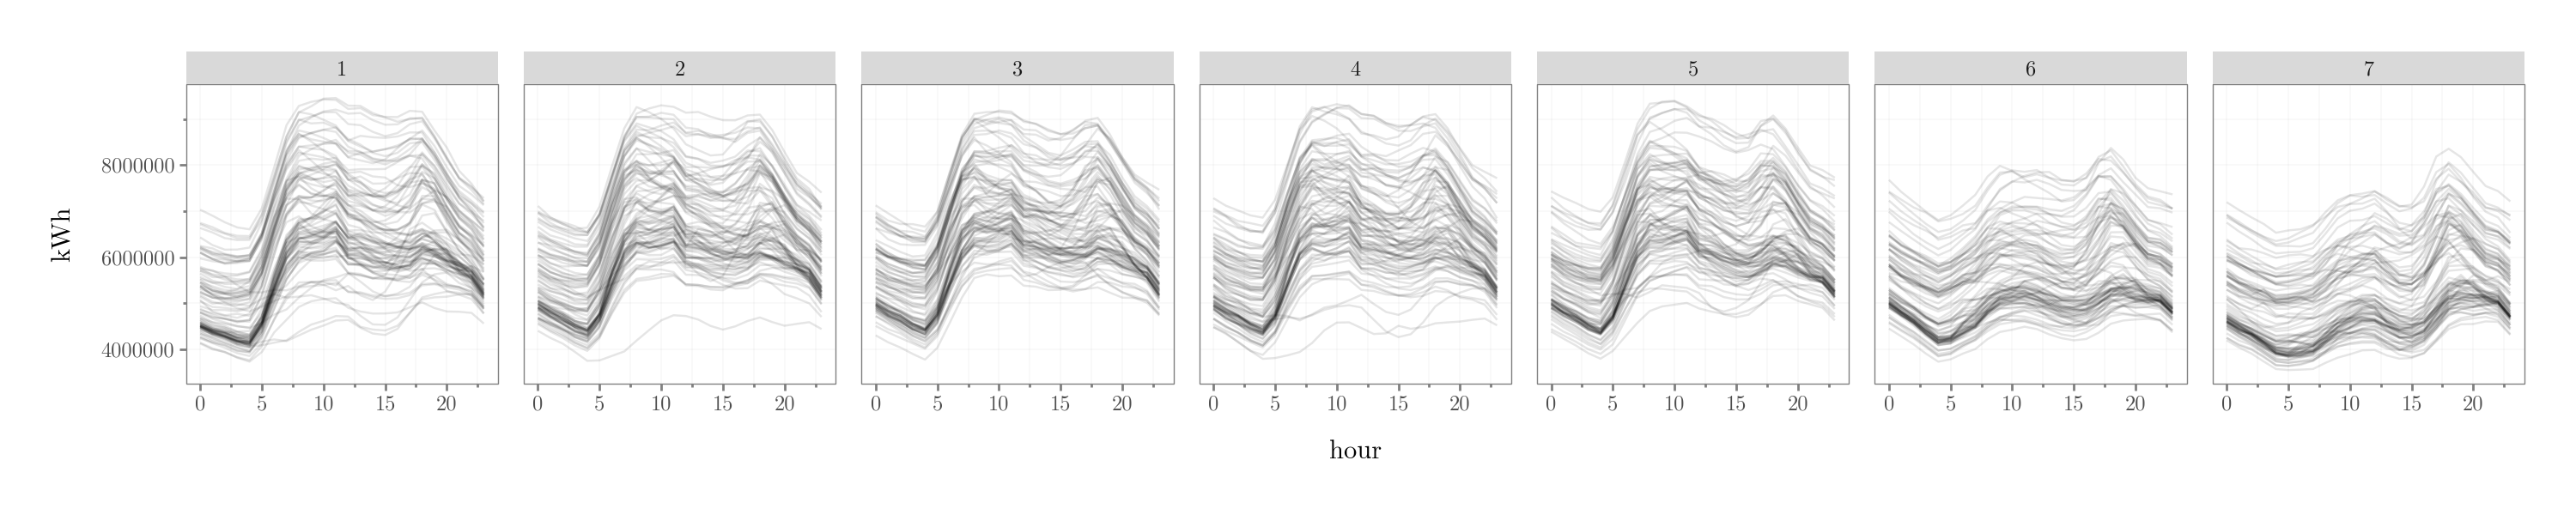

In [28]:
(
    pn.ggplot(
        data=df.with_columns(
            hour=pl.col("datetime").dt.hour(),
            date=pl.col("datetime").dt.date(),
            weekday=pl.col("datetime").dt.weekday(),
        )
        .filter(pl.col("datetime").dt.year() >= 2023)
        .with_columns(),
        mapping=pn.aes("hour", "kWh", group="date"),
    )
    + pn.geom_line(alpha=0.1)
    + pn.facet_wrap("~ weekday", nrow=1)
    + theme_academic
    + pn.theme(figure_size=(15, 3))
)

In [29]:
df_full = df.to_pandas().set_index("datetime")

In [30]:
df_trainval = df_full["2021-09-01":"2023-08-31"]
df_holdout = df_full["2023-09-01":"2024-08-31"]

In [31]:
df_holdout.reset_index().filter(["datetime"]).assign(
    delta=lambda x: x.datetime - x.datetime.shift(1)
)["delta"].value_counts()

delta
0 days 01:00:00    8783
Name: count, dtype: int64

In [32]:
retraining_freq = 7 * 24
retraining_indices = np.arange(0, df_holdout.shape[0], retraining_freq).tolist()
y_preds = []

for holdout_index in tqdm(retraining_indices):

    # Preprocess training history (only use the last four weeks)
    X_train = pd.concat(
        [
            df_trainval.iloc[holdout_index:],
            df_holdout.iloc[:holdout_index],
        ],
        axis=0,
    ).tail(24 * 7 * 4)

    X_holdout = df_holdout.iloc[holdout_index : holdout_index + retraining_freq]

    # Calculate historical averages
    historical_averages = (
        X_train.reset_index()
        .assign(
            weekday=lambda x: x.datetime.dt.weekday, hour=lambda x: x.datetime.dt.hour
        )
        .groupby(["weekday", "hour"])
        .agg(pred=("kWh", "mean"))
        .reset_index()
    )

    # Join historical averages onto the new data as predictions
    y_pred = (
        X_holdout.reset_index()
        .assign(
            weekday=lambda x: x.datetime.dt.weekday, hour=lambda x: x.datetime.dt.hour
        )
        .merge(historical_averages, how="left", on=["weekday", "hour"])
        .filter(["datetime", "kWh", "pred"])
    )
    y_preds.append(y_pred)

    # Increment holdout index
    holdout_index += retraining_freq

  0%|          | 0/53 [00:00<?, ?it/s]

In [33]:
holdout_preds = pd.concat(y_preds)
holdout_preds.head()

,datetime,kWh,pred
0,2023-09-01 00:00:00,4.952079e+06,4.863710e+06
1,2023-09-01 01:00:00,4.789383e+06,4.680617e+06
2,2023-09-01 02:00:00,4.689283e+06,4.557776e+06
3,2023-09-01 03:00:00,4.490485e+06,4.373226e+06
4,2023-09-01 04:00:00,4.345052e+06,4.252319e+06


In [ ]:
holdout_preds.to_csv("06_NAIVE_holdout_predictions.csv", index=False)

In [35]:
# Create the figure with step lines for both actual and predicted values
fig = px.line(
    pd.concat(y_preds).reset_index(),
    x="datetime",
    y=["kWh", "pred"],
    labels={
        "datetime": "Date",
        "value": "Energy Consumption (kWh)",
        "variable": "Series",
    },
    title="Actual vs Predicted Energy Consumption Over Time",
    line_shape="hv",  # Set line shape to horizontal-vertical for step chart
)

# Customize the layout
fig.update_layout(
    template="plotly_white",
    legend=dict(title=""),
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
)

# Show the figure
fig.show()